# Uncertainty quantification for cross sections
This tutorial will demonstrate how to use jitr to perform uncertainty quantification of a simple reaction observable: differential elastic scattering cross sections. We will use the following uncertainty quantified optical potentials:
- KDUQ introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602). 
- CHUQ also introduced here: [[Pruitt et al., 2024]](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602).
- WLH from [[Whitehead et al., 2021]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.127.182502)

     
jitR includes an implementation of each of these, as well as samples from their respecctive posteriors

In [1]:
from pathlib import Path

import corner

# import stuff for nice plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from numba import njit
from scipy import stats
from tqdm import tqdm

import jitr

In [2]:
from jitr.optical_potentials import chuq, kduq, wlh

In [3]:
#  elastic reaction
target = (54, 26)
proton = (1, 1)
neutron = (1, 0)
projectile = proton

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

In [4]:
quantity = "dXS/dRuth"
# quantity = "dXS/dA"
assert not (projectile == neutron and quantity == "dXS/dRuth")

### Let's find some data to compare to
Let's grab some data from [EXFOR](https://www-nds.iaea.org/exfor/).

In [5]:
#! pip install exfor-tools
import exfor_tools

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
all_entries, failed_parses = exfor_tools.curate.query_for_entries(
    exfor_tools.reaction.ElasticReaction(target=target, projectile=projectile),
    quantity=quantity,
    Einc_range=[7, 60],  # MeV
)
all_measurements = exfor_tools.curate.categorize_measurements_by_energy(all_entries)

In [7]:
all_entries.keys()

dict_keys(['O0240', 'O0788', 'O1243'])

In [8]:
all_entries_Ay, failed_parses = exfor_tools.curate.query_for_entries(
    exfor_tools.reaction.Reaction(target=target, projectile=projectile, process="EL"),
    quantity="Ay",
    Einc_range=[7, 60],  # MeV
)
all_measurements_Ay = exfor_tools.curate.categorize_measurements_by_energy(
    all_entries_Ay
)

(0.0, 205.0)

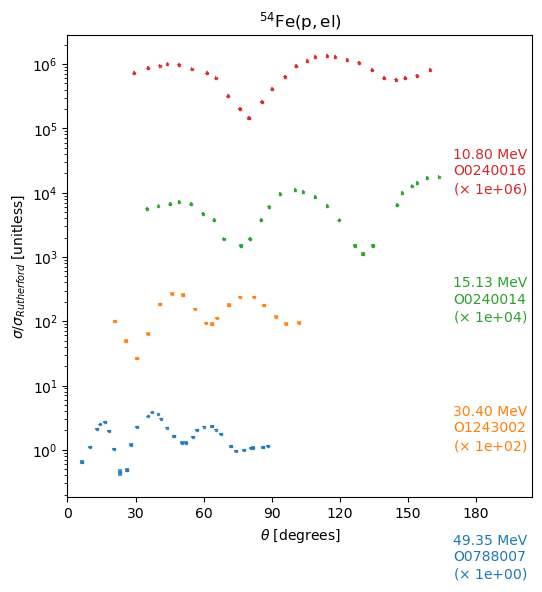

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
exfor_keys = list(all_entries.keys())
exfor_tools.distribution.AngularDistribution.plot(
    all_measurements,
    ax,
    offsets=100,
    data_symbol=list(all_entries.values())[0].data_symbol,
    rxn_label=f"${list(all_entries.values())[0].reaction.reaction_latex}$",
    label_kwargs={
        "label_offset_factor": 0.01,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 170,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 205])

(0.0, 205.0)

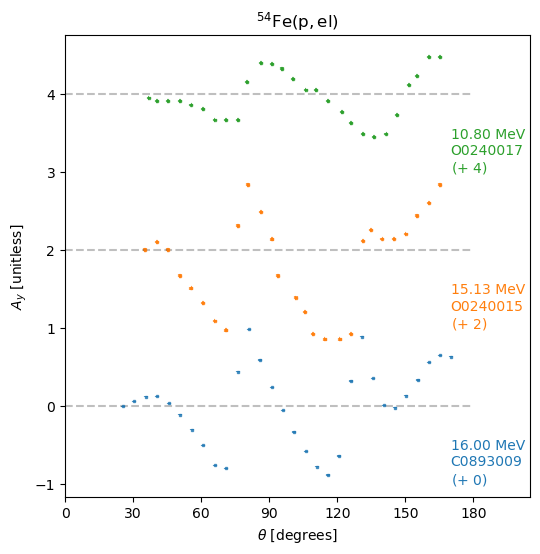

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
exfor_keys = list(all_entries_Ay.keys())
exfor_tools.distribution.AngularDistribution.plot(
    all_measurements_Ay,
    ax,
    offsets=2,
    data_symbol=list(all_entries_Ay.values())[0].data_symbol,
    rxn_label=f"${list(all_entries.values())[0].reaction.reaction_latex}$",
    draw_baseline=True,
    baseline_offset=0,
    log=False,
    label_kwargs={
        "label_offset_factor": -1,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 170,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 205])

### Let's set up our solver to calculate differential cross sections

In [11]:
solvers = []
solvers_Ay = []

core_solver = jitr.rmatrix.Solver(40)
reaction = jitr.reactions.ElasticReaction(
    target=target,
    projectile=projectile,
)


for measurements in all_measurements:
    measurement = measurements[0]
    Elab = measurement.Einc

    # get kinematics and parameters for this experiment
    kinematics = reaction.kinematics(Elab)

    a = jitr.utils.interaction_range(target[0]) * kinematics.k + np.pi * 2
    N = jitr.utils.suggested_basis_size(a)
    assert N < core_solver.kernel.quadrature.nbasis
    channel_radius_fm = a / kinematics.k

    solvers.append(
        jitr.xs.elastic.DifferentialWorkspace.build_from_system(
            reaction=reaction,
            kinematics=kinematics,
            channel_radius_fm=channel_radius_fm,
            solver=core_solver,
            lmax=50,
            angles=angles,
        )
    )

for measurements in all_measurements_Ay:
    measurement = measurements[0]
    Elab = measurement.Einc

    # get kinematics and parameters for this experiment
    kinematics = reaction.kinematics(Elab)

    a = jitr.utils.interaction_range(target[0]) * kinematics.k + np.pi * 2
    N = jitr.utils.suggested_basis_size(a)
    assert N < core_solver.kernel.quadrature.nbasis
    channel_radius_fm = a / kinematics.k

    solvers_Ay.append(
        jitr.xs.elastic.DifferentialWorkspace.build_from_system(
            reaction=reaction,
            kinematics=kinematics,
            channel_radius_fm=channel_radius_fm,
            solver=core_solver,
            lmax=50,
            angles=angles,
        )
    )

# Now that we have the solvers set up, let's run the UQ!

### First let's grab posterior samples from each of our optical potentials

In [12]:
kduq_samples = kduq.get_samples_federal(projectile)
chuq_samples = chuq.get_samples_federal() # Lane consistent
wlh_samples = wlh.get_samples(projectile)

## KDUQ:

In [13]:
kduq_pred_post = []
kduq_pred_post_Ay = []

for i in range(len(all_measurements)):
    # get a differential xs for each parameter sample
    kduq_xs = np.zeros((len(angles), kduq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(kduq_samples)):
        coulomb_params, central_params, spin_orbit_params = kduq.calculate_params(
            projectile, target, solvers[i].kinematics.Elab, *sample
        )

        xs = solvers[i].xs(
            kduq.central_plus_coulomb,
            kduq.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        kduq_xs[:, j] = xs.dsdo

    kduq_pred_post.append(np.percentile(kduq_xs, [5, 95], axis=1))

for i in range(len(all_measurements_Ay)):
    # get a differential xs for each parameter sample
    kduq_ay = np.zeros((len(angles), kduq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(kduq_samples)):
        coulomb_params, central_params, spin_orbit_params = kduq.calculate_params(
            projectile, target, solvers_Ay[i].kinematics.Elab, *sample
        )

        xs = solvers_Ay[i].xs(
            kduq.central_plus_coulomb,
            kduq.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        kduq_ay[:, j] = xs.Ay

    kduq_pred_post_Ay.append(np.percentile(kduq_ay, [5, 95], axis=1))

 92%|██████████████████████████████████████████████████████▉     | 381/416 [00:10<00:00, 208.53it/s]/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:397: RuntimeWarning: overflow encountered in exp
  d2 = d2_0 + d2_A / (1 + np.exp((A - d2_A3) / d2_A2))
100%|████████████████████████████████████████████████████████████| 416/416 [00:01<00:00, 366.85it/s]


## CHUQ:

In [14]:
chuq_pred_post = []
chuq_pred_post_Ay = []

for i in range(len(all_measurements)):
    # get a differential xs for each parameter sample
    chuq_xs = np.zeros((len(angles), chuq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(chuq_samples)):
        coulomb_params, central_params, spin_orbit_params = chuq.calculate_params(
            projectile, target, solvers[i].kinematics.Elab, *sample
        )

        xs = solvers[i].xs(
            chuq.central_plus_coulomb,
            chuq.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        chuq_xs[:, j] = xs.dsdo
    chuq_pred_post.append(np.percentile(chuq_xs, [5, 95], axis=1))

for i in range(len(all_measurements_Ay)):
    # get a differential xs for each parameter sample
    chuq_ay = np.zeros((len(angles), chuq.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(chuq_samples)):
        coulomb_params, central_params, spin_orbit_params = chuq.calculate_params(
            projectile, target, solvers_Ay[i].kinematics.Elab, *sample
        )

        xs = solvers_Ay[i].xs(
            chuq.central_plus_coulomb,
            chuq.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        chuq_ay[:, j] = xs.Ay

    chuq_pred_post_Ay.append(np.percentile(chuq_ay, [5, 95], axis=1))

100%|████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 386.93it/s]


## WLH:

In [15]:
wlh_pred_post = []
wlh_pred_post_Ay = []

for i in range(len(all_measurements)):
    # get a differential xs for each parameter sample
    wlh_xs = np.zeros((len(angles), wlh.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(wlh_samples)):
        coulomb_params, central_params, spin_orbit_params = wlh.calculate_params(
            projectile, target, solvers[i].kinematics.Elab, *sample
        )

        xs = solvers[i].xs(
            wlh.central_plus_coulomb,
            wlh.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        wlh_xs[:, j] = xs.dsdo

    # get credible intervals describing the KDUQ predictive posterior
    # for this experiment
    wlh_pred_post.append(np.percentile(wlh_xs, [5, 95], axis=1))

for i in range(len(all_measurements_Ay)):
    # get a differential xs for each parameter sample
    wlh_ay = np.zeros((len(angles), wlh.NUM_POSTERIOR_SAMPLES))

    for j, sample in enumerate(tqdm(wlh_samples)):
        coulomb_params, central_params, spin_orbit_params = wlh.calculate_params(
            projectile, target, solvers_Ay[i].kinematics.Elab, *sample
        )

        xs = solvers_Ay[i].xs(
            wlh.central_plus_coulomb,
            wlh.spin_orbit,
            (central_params, coulomb_params),
            spin_orbit_params,
        )
        wlh_ay[:, j] = xs.Ay

    wlh_pred_post_Ay.append(np.percentile(wlh_ay, [5, 95], axis=1))

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 400.40it/s]


Now that we have our model predictions, lets plot them compared to the experimental data. We will offset each energy for visibility.

## Plotting results:

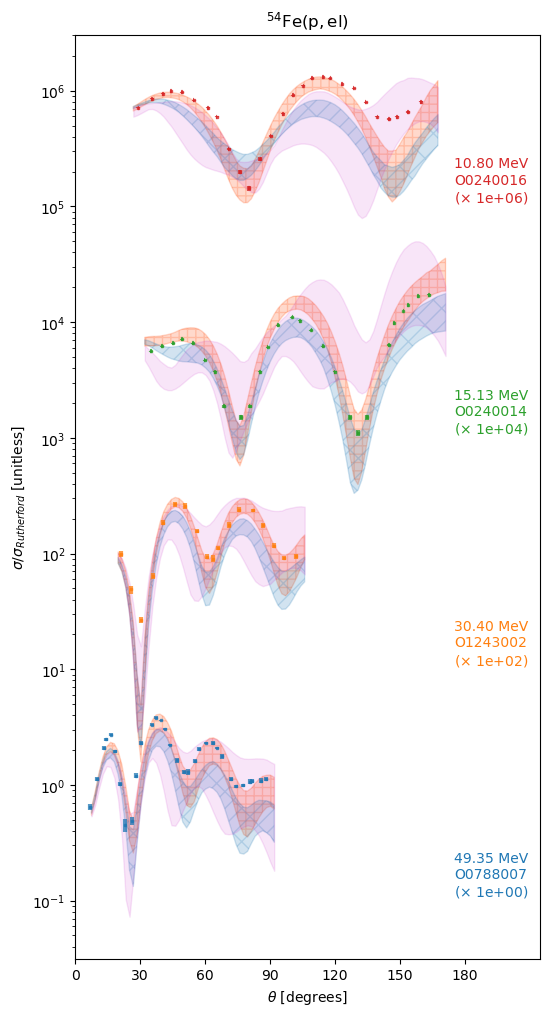

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
offsets = exfor_tools.distribution.AngularDistribution.plot(
    all_measurements,
    ax,
    offsets=100,
    data_symbol=list(all_entries.values())[0].data_symbol,
    rxn_label=f"${list(all_entries.values())[0].reaction.reaction_latex}$",
    label_kwargs={
        "label_offset_factor": 0.11,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 175,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 215])

for i in range(len(all_measurements)):
    xmin = min([np.min(m.x) for m in all_measurements[i]]) * np.pi / 180
    xmax = max([np.max(m.x) for m in all_measurements[i]]) * np.pi / 180
    mask = np.logical_and(angles >= xmin * 0.9, angles < xmax * 1.05)

    # plot models
    if quantity == "dXS/dA":
        ax.fill_between(
            angles[mask] * 180 / np.pi,
            offsets[i] * kduq_pred_post[i][0][mask] / 1000,
            offsets[i] * kduq_pred_post[i][1][mask] / 1000,
            color="#ff4500",
            hatch="|-|-",
            alpha=0.2,
        )
        ax.fill_between(
            angles[mask] * 180 / np.pi,
            offsets[i] * chuq_pred_post[i][0][mask] / 1000,
            offsets[i] * chuq_pred_post[i][1][mask] / 1000,
            color="tab:blue",
            hatch="/\/",
            alpha=0.2,
        )
        ax.fill_between(
            angles[mask] * 180 / np.pi,
            offsets[i] * wlh_pred_post[i][0][mask] / 1000,
            offsets[i] * wlh_pred_post[i][1][mask] / 1000,
            color="m",
            alpha=0.1,
        )
    elif quantity == "dXS/dRuth":
        ax.fill_between(
            angles[mask] * 180 / np.pi,
            offsets[i] * kduq_pred_post[i][0][mask] / solvers[i].rutherford[mask],
            offsets[i] * kduq_pred_post[i][1][mask] / solvers[i].rutherford[mask],
            color="#ff4500",
            hatch="|-|-",
            alpha=0.2,
        )
        ax.fill_between(
            angles[mask] * 180 / np.pi,
            offsets[i] * chuq_pred_post[i][0][mask] / solvers[i].rutherford[mask],
            offsets[i] * chuq_pred_post[i][1][mask] / solvers[i].rutherford[mask],
            color="tab:blue",
            hatch="/\/",
            alpha=0.2,
        )
        ax.fill_between(
            angles[mask] * 180 / np.pi,
            offsets[i] * wlh_pred_post[i][0][mask] / solvers[i].rutherford[mask],
            offsets[i] * wlh_pred_post[i][1][mask] / solvers[i].rutherford[mask],
            color="m",
            alpha=0.1,
        )

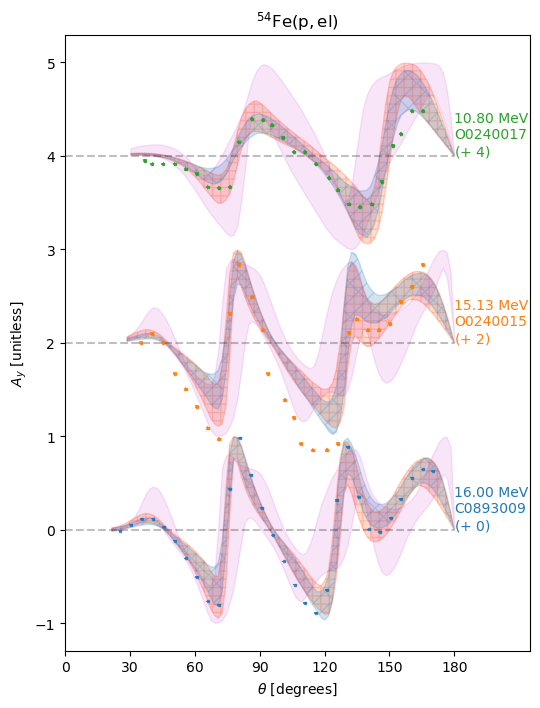

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
exfor_keys = list(all_entries_Ay.keys())
offsets = exfor_tools.distribution.AngularDistribution.plot(
    all_measurements_Ay,
    ax,
    offsets=2,
    data_symbol=list(all_entries_Ay.values())[0].data_symbol,
    rxn_label=f"${list(all_entries.values())[0].reaction.reaction_latex}$",
    draw_baseline=True,
    baseline_offset=0,
    log=False,
    label_kwargs={
        "label_offset_factor": 0,
        "label_offset": True,
        "label_exfor": True,
        "label_xloc_deg": 180,
        "label_energy_err": False,
    },
)
ax.set_xlim([0, 215])
for i in range(len(all_measurements_Ay)):
    # get x_range
    xmin = min([np.min(m.x) for m in all_measurements_Ay[i]]) * np.pi / 180
    xmax = max([np.max(m.x) for m in all_measurements_Ay[i]]) * np.pi / 180
    mask = np.logical_and(angles >= xmin * 0.8, angles < xmax * 1.2)
    # plot models
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] + kduq_pred_post_Ay[i][0][mask],
        offsets[i] + kduq_pred_post_Ay[i][1][mask],
        color="#ff4500",
        hatch="|-|-",
        alpha=0.2,
    )
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] + chuq_pred_post_Ay[i][0][mask],
        offsets[i] + chuq_pred_post_Ay[i][1][mask],
        color="tab:blue",
        hatch="/\/",
        alpha=0.2,
    )
    ax.fill_between(
        angles[mask] * 180 / np.pi,
        offsets[i] + wlh_pred_post_Ay[i][0][mask],
        offsets[i] + wlh_pred_post_Ay[i][1][mask],
        color="m",
        alpha=0.1,
    )